## Train the game prediction models
* Aggregate game-level dataframe into season-level statistics
* Compute statistics on first X% of the season, and predict games in final (100-X)% (e.g. X=70)
* Compute "advanced stats" (efficiency, effective field goal percentage, assist ratio, OReb ratio,
turnover rate) corrected for strength-of-schedule
* Engineer orthogonal features with PCA
* Try a variety of logistic regression and BDT models to predict probabilistic outcome
* Linear regressions to predict pace, total score, score margin

In [1]:
import os
import glob
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import watchcbb.utils as utils
import watchcbb.efficiency as eff
import watchcbb.sql as sql

### Load game-level dataframe

In [2]:
df = sql.df_from_query(""" SELECT * FROM game_data """)
df.head(10)

,Season,Date,gid,Type,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,poss
0,2011,2010-11-08,2010-11-08_california-irvine_illinois,RG,illinois,79,california-irvine,65,H,0,...,14,22,11,26,12,14,7,1,21,74.90
1,2011,2010-11-08,2010-11-08_pittsburgh_rhode-island,RG,pittsburgh,83,rhode-island,75,H,0,...,13,16,9,20,16,16,7,6,25,75.62
2,2011,2010-11-08,2010-11-08_maryland_seattle,RG,maryland,105,seattle,76,H,0,...,17,22,13,16,11,27,18,1,31,98.36
3,2011,2010-11-08,2010-11-08_navy_texas,RG,texas,83,navy,52,H,0,...,10,18,5,21,8,16,5,5,24,80.44
4,2011,2010-11-10,2010-11-10_college-of-charleston_maryland,RG,maryland,75,college-of-charleston,74,H,0,...,16,19,10,25,12,22,8,8,19,77.64
5,2011,2010-11-10,2010-11-10_illinois-chicago_pittsburgh,RG,pittsburgh,97,illinois-chicago,54,H,0,...,7,9,5,15,9,11,0,3,18,67.88
6,2011,2010-11-10,2010-11-10_illinois_toledo,RG,illinois,84,toledo,45,H,0,...,10,19,3,16,9,23,6,0,14,72.00
7,2011,2010-11-10,2010-11-10_louisiana-tech_texas,RG,texas,89,louisiana-tech,58,H,0,...,13,20,13,25,4,22,6,5,21,83.74
8,2011,2010-11-12,2010-11-12_maryland-eastern-shore_tulane,RG,tulane,91,maryland-eastern-shore,62,A,0,...,19,26,9,16,11,21,4,2,28,78.04
9,2011,2010-11-12,2010-11-12_marquette_prairie-view,RG,marquette,97,prairie-view,58,H,0,...,7,11,3,13,12,20,11,3,27,79.12


### Partition each season into two parts: one to compute statistics, and one containg games to predict

In [3]:
FRAC = 0.7
first, second = utils.partition_games(df, frac=FRAC)
print(df.iloc[first].shape[0], df.iloc[second].shape[0])

38328 16432


### Compute aggregated stats as well as some composite advanced metrics

In [4]:
season_stats_dict = utils.compute_season_stats(df.iloc[first])
season_stats_df = utils.stats_dict_to_df(season_stats_dict)
utils.add_advanced_stats(season_stats_df)
season_stats_dict = utils.stats_df_to_dict(season_stats_df)
print(season_stats_df.shape)
season_stats_df.head()

(3497, 54)


,year,team_id,wins,losses,totOT,TScore,TFGM,TFGA,TFGM3,TFGA3,...,Torbp,Tftr,Oposs,Oeff,Oastr,Otovr,Oefgp,Oorbp,Oftr,rawpace
0,2011,air-force,12,8,2,1328,463,941,133,333,...,0.196078,0.414453,1261.96,101.825731,0.157057,0.169381,0.485780,0.338073,0.283486,61.890370
1,2011,akron,12,10,2,1498,527,1263,175,508,...,0.262003,0.306413,1522.28,96.434296,0.137450,0.190418,0.480897,0.315789,0.383721,68.349663
2,2011,alabama,15,7,1,1493,566,1249,96,311,...,0.356601,0.293034,1502.48,83.595123,0.110456,0.199252,0.409393,0.300525,0.346633,67.763164
3,2011,alabama-am,6,10,0,959,348,896,62,237,...,0.282004,0.377232,1143.32,90.875695,0.136156,0.209393,0.472254,0.323194,0.399773,71.501250
4,2011,alabama-birmingham,16,6,5,1537,547,1224,166,480,...,0.312789,0.307190,1472.84,94.375492,0.130914,0.164221,0.457404,0.308123,0.287420,64.801768


### Now correct everything for strength of schedule
The Top 25 "efficiency ratings" for a certain year are printed below

In [5]:
eff.compute_efficiency_ratings(season_stats_dict)
season_stats_df = utils.stats_dict_to_df(season_stats_dict)

In [6]:
season_stats_df[["year","team_id","Tneteff","Tcorroeff","Tcorrdeff","rawpace","pace"]]\
    .query('year==2018')\
    .sort_values('Tneteff', ascending=False).reset_index(drop=True).head(25)

,year,team_id,Tneteff,Tcorroeff,Tcorrdeff,rawpace,pace
0,2018,villanova,37.704624,129.875622,92.170999,71.399091,70.655607
1,2018,purdue,34.744862,123.527746,88.782883,70.041791,70.441197
2,2018,virginia,33.937097,114.337084,80.399987,62.175652,61.678752
3,2018,duke,33.138386,126.930286,93.791900,73.603459,74.109624
4,2018,michigan-state,32.956865,121.238851,88.281986,70.227264,69.254485
5,2018,kansas,29.035391,121.047887,92.012496,72.153913,71.691346
6,2018,cincinnati,27.955425,111.624540,83.669115,68.833636,68.384579
7,2018,texas-tech,26.202681,112.618354,86.415673,69.811613,68.835404
8,2018,tennessee,26.156499,115.798850,89.642351,68.925843,68.868866
9,2018,xavier,24.345483,120.257686,95.912202,72.955855,72.412131


### Put everything into a tidy dataframe for training models
* Randomly pick which team to use as "reference" team for relative statistics, so classes are balanced
* Add in a bunch of features that we may need for model fitting

In [7]:
data = utils.compile_training_data(df.iloc[second], season_stats_dict, random_seed=1)
print(data.shape)
data.query("tid1=='purdue' | tid2=='purdue'").sample(frac=1, random_state=1).head(10)

(16432, 26)


,season,date,tid1,tid2,result,totscore,margin,HA,poss,pace1,...,Torbp,Ttovr,Tftr,Tastr,Oefgp,Oeff,Tefgp,Oftr,Oorbp,Otovr
10692,2017,2017-02-25,purdue,michigan,0,152,-12,-1,64.68,71.452744,...,0.056245,0.031144,0.020341,0.035118,-0.060768,-9.570001,0.019865,-0.056239,-0.048833,-0.026247
5532,2014,2014-02-23,nebraska,purdue,1,133,19,1,71.82,67.236594,...,-0.105181,0.007118,0.098607,-0.018887,0.027760,0.876905,0.032322,0.054069,-0.043847,0.007570
9669,2016,2016-03-12,michigan,purdue,0,135,-17,0,69.60,66.376917,...,-0.094658,-0.024098,-0.055055,-0.007039,0.072586,10.919124,0.050068,-0.022938,0.052403,0.030469
12278,2018,2018-02-22,illinois,purdue,0,179,-7,1,69.02,73.022724,...,0.067415,0.031345,-0.017028,-0.052952,0.061853,7.746202,-0.089788,0.215292,0.008262,0.049848
6167,2014,2014-03-09,northwestern,purdue,1,139,9,-1,68.54,63.739988,...,-0.165682,0.012880,0.007175,0.002910,-0.026544,-4.616429,-0.006669,-0.002722,-0.035408,-0.018680
9200,2016,2016-03-01,purdue,nebraska,1,143,19,-1,65.04,71.056794,...,0.033286,0.004747,0.008917,0.052912,-0.062140,-12.477338,0.020779,-0.128684,-0.062344,-0.031991
9028,2016,2016-02-27,maryland,purdue,0,162,-4,-1,67.36,68.378760,...,-0.035513,0.015145,0.016878,-0.022277,0.018857,5.093022,0.042579,-0.006785,0.060298,0.002985
13585,2019,2019-02-19,indiana,purdue,0,94,-2,1,64.44,69.501506,...,-0.104259,0.027091,0.054414,-0.014661,-0.023140,-3.561095,-0.026265,-0.044120,0.011251,-0.024639
4752,2013,2013-03-20,purdue,western-illinois,1,148,14,1,62.50,67.940167,...,0.141213,-0.016247,-0.046855,0.008413,-0.024026,-0.198411,-0.008216,0.006509,-0.023393,-0.003987
9652,2016,2016-03-11,purdue,illinois,1,147,31,0,66.22,71.056794,...,0.152116,0.024638,-0.007900,0.034749,-0.098564,-15.249778,0.026129,0.014907,-0.076218,-0.031069


### Plot histograms of various features for winning/losing teams

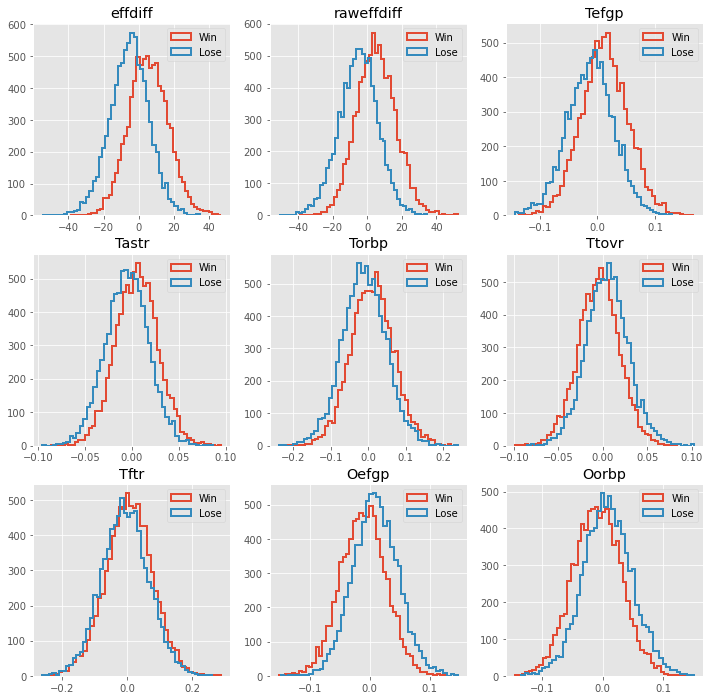

In [8]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
axs = axs.flatten()
toplot = ['effdiff','raweffdiff','Tefgp',
          'Tastr','Torbp', 'Ttovr', 
          'Tftr','Oefgp','Oorbp'
         ]
for name,ax in zip(toplot,axs):
    ax.hist(data.loc[ data.result.astype(bool)][name], bins=50, histtype='step', lw=2, label='Win')
    ax.hist(data.loc[~data.result.astype(bool)][name], bins=50, histtype='step', lw=2, label='Lose')
    ax.set_title(name)
    ax.legend()

### Various advanced stat features are highly correlated, so try running them through a PCA
Decent separation along first dimension. Even though this explains contains ~30% of the total variance,
it seems like other dimensions have relatively little discriminating power.

array([0.28961986, 0.19657634, 0.10633909, 0.09546326, 0.08296091,
       0.06286674, 0.06204601, 0.05225432, 0.03055973, 0.01866449,
       0.00153923, 0.00111004])

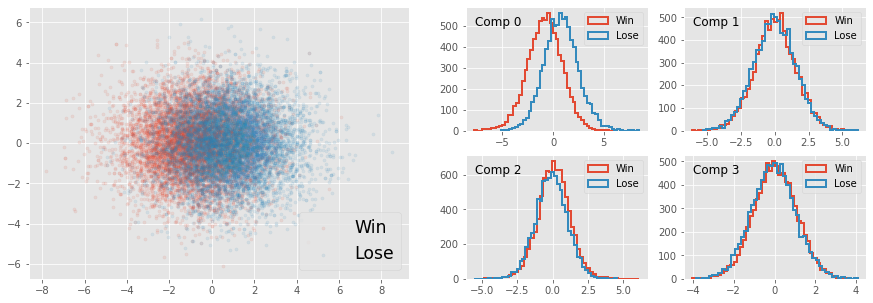

In [9]:
pca = utils.get_pca_model()

xf = pca.fit_transform(data[utils.ADVSTATFEATURES])
plt.figure(figsize=(15,5))
mask = data.result.astype(bool)
plt.subplot(1,2,1)
plt.scatter(xf[mask,0], xf[mask,1], s=10, alpha=0.1, label="Win")
plt.scatter(xf[~mask,0], xf[~mask,1], s=10, alpha=0.1, label="Lose")
plt.legend(fontsize='xx-large')
for i,subplot in zip([0,1,2,3],[3,4,7,8]):
    plt.subplot(2,4,subplot)
    plt.hist(xf[mask,i], bins=50, histtype='step', lw=2, label='Win')
    plt.hist(xf[~mask,i], bins=50, histtype='step', lw=2, label='Lose')
#     plt.title('Comp '+str(i))
    plt.text(0.05,0.85,'Comp '+str(i), transform=plt.gca().transAxes, fontsize='large')
    plt.legend()
pca.named_steps['pca'].components_[0,:]
pca.named_steps['pca'].explained_variance_ratio_

### Remove two years at a time for a validation set and perform 5-fold cross validation
We try a variety of models:
* "HA" : as a baseline, a logistic regression using **only** home/away feature
* "raweffdiff" : Logistic regression using only raw efficiencies (non-SoS-corrected) and home/away. Expected to perform poorly
* "effdiff" : use SoS-corrected efficiencies
* "advstats" : Use PCA features derived above
* "advstats_xgb" : Same as above but XGBClassifier instead of logistic regression

"advstats" logistic regression with PCA values performs best in 4 out of 5 folds, and is a close second in the 5th.

advstats  : 0.5734
effdiff   : 0.5724
advstats_xgb: 0.5699
raweffdiff: 0.5642


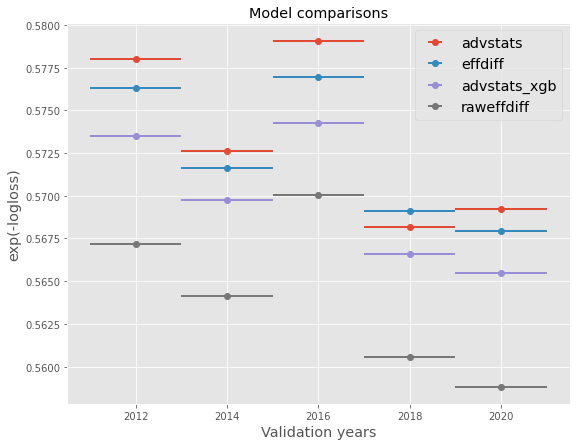

In [11]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
    
logreg = LogisticRegression(C=1.0)
xgbcls = XGBClassifier(max_depth=2, n_estimators=50)

PCAFEATURES = ["PCA"+str(i) for i in range(len(utils.ADVSTATFEATURES))]
models = {
#     "HA" : [],
    "raweffdiff" : ["raweffdiff"],    
    "effdiff" : ["effdiff"],
#     "bad" : ["Otovr"],
    "advstats" : PCAFEATURES,
    "advstats_xgb" : PCAFEATURES
}

model_scores = defaultdict(list)
model_coeffs = defaultdict(list)
years = data.season.unique()
NVALID = 2
start_years = years[:len(years)-NVALID+1:NVALID]
for start_valid in start_years:
    valid_years = list(range(start_valid, start_valid+NVALID))
    train_years = sorted(set(years)-set(valid_years))
    
    data_train, data_valid = utils.train_test_split_by_year(data, train_years, valid_years, pca_model=pca)
    
    for name,features in models.items():
        X_train = data_train[features+['HA']]
        y_train = data_train.result
        X_valid = data_valid[features+['HA']]
        y_valid = data_valid.result
        
        if "xgb" not in name:
            logreg.fit(X_train, y_train)
            probs = logreg.predict_proba(X_valid)
            score = log_loss(y_valid, probs)
            model_scores[name].append(np.exp(-score))
            model_coeffs[name].append(logreg.coef_[0,:])
        else:
            xgbcls.fit(X_train, y_train)
            probs = xgbcls.predict_proba(X_valid)
            score = log_loss(y_valid, probs)
            model_scores[name].append(np.exp(-score))

plt.figure(figsize=(9,7))
xs = start_years
for name,scores in sorted(model_scores.items(), key=lambda x:np.mean(x[1]), reverse=True):
    print(f'{name:10s}: {np.mean(scores):.4f}')
    plt.errorbar(xs+NVALID/2.0, scores, xerr=NVALID/2.0, fmt='o', lw=2, label=name)
plt.xlabel('Validation years', fontsize='x-large')
plt.ylabel('exp(-logloss)', fontsize='x-large')
plt.title('Model comparisons')
plt.legend(fontsize='x-large');

# model_coeffs['advstats']

### Just to make sure we didn't accidentally miss a good model, try a few XGBClassifiers over a grid of hyperparameters
Does not outperform logistic regression.

In [12]:
data_train, data_valid = utils.train_test_split_by_year(data, list(range(2011,2018)), [2018,2019,2020], pca_model=pca)

best = (0,0,0)
for i in [2,3,4]:
    for j in [10,20,50,100]:
        xgbcls = XGBClassifier(max_depth=i, n_estimators=j)
        xgbcls.fit(X_train, y_train)
        probs = xgbcls.predict_proba(X_valid)
        score = np.exp(-log_loss(y_valid, probs))
        if score > best[2]:
            best = (i,j,score)
print('(max_depth, n_estimatores, best_score)',best)

(max_depth, n_estimatores, best_score) (2, 50, 0.5654956316736102)


### Generate predictions for every game using other years as training
So we can make some pretty plots.

In [14]:
probs = []
for year in data.season.unique():
    train_years = data.season.unique().tolist()
    train_years.remove(year)
    data_train, data_valid = utils.train_test_split_by_year(data, train_years, [year], pca_model=pca)
    X_train = data_train[PCAFEATURES+['HA']]
    y_train = data_train.result
    X_valid = data_valid[PCAFEATURES+['HA']]
    
    logreg.fit(X_train, y_train)
    probs += logreg.predict_proba(X_valid)[:,1].tolist()

data["predicted_prob"] = probs
data[['result','predicted_prob']].head(5)

,result,predicted_prob
0,1,0.697178
1,1,0.783223
2,0,0.284963
3,0,0.283500
4,1,0.620096


### Check model calibration by plotting observed win % in bins of predicted probability
This falls on a straight line, showing that generated probabilities are meaningful

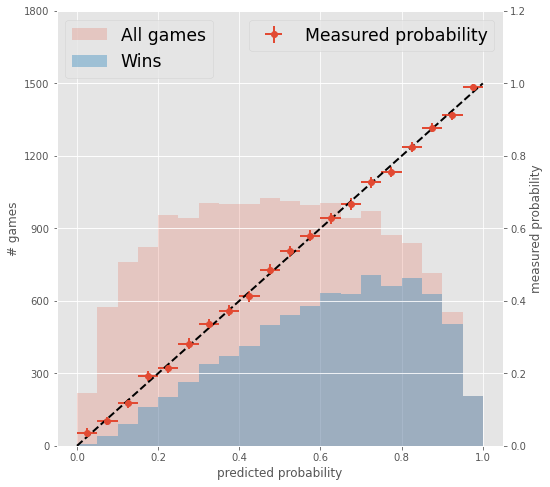

In [15]:
binedges = np.linspace(0,1,21)
ws = []
errs = []
for i in range(len(binedges)-1):
    num = ((data.predicted_prob > binedges[i]) & (data.predicted_prob < binedges[i+1]) & data.result).sum()
    den = ((data.predicted_prob > binedges[i]) & (data.predicted_prob < binedges[i+1])).sum()
    f = num/den
    ws.append(f)
    errs.append(np.sqrt(f*(1-f)/den))
fig, ax1 = plt.subplots(figsize=(8,8))
plt.hist(data.predicted_prob, bins=binedges, histtype='stepfilled', lw=2, alpha=0.2, label='All games')
plt.hist(data.predicted_prob[data.result.astype(bool)], bins=binedges, histtype='stepfilled', lw=2, alpha=0.4, label='Wins')
plt.xlabel('predicted probability')
plt.ylabel('# games')
plt.gca().set_ylim(0,1800)
plt.yticks(range(0,1801,300))
plt.legend(loc='upper left', fontsize='xx-large')
ax2 = ax1.twinx()
plt.plot([0,1],[0,1],'k--',lw=2)
plt.errorbar(0.5*(binedges[:-1]+binedges[1:]), ws, yerr=errs, xerr=0.5*(binedges[1]-binedges[0]), 
            fmt = 'o', lw=2, label='Measured probability')
plt.xlabel('predicted probability')
plt.ylabel('measured probability')
plt.gca().set_ylim(0,1.2)
plt.legend(fontsize='xx-large')

### Perform some linear regressions to predict pace, total score, score margin

Regression for pace
[0.01469658] -1.7813656105003446
0.30416074057388276
3.8128882557593426
Regression for total score
[0.00475375] 9.755760752346731
0.22455751593248097
13.777312773587811
Regression for score margin
[0.01086386 4.33627717] -0.044907577262105744
0.31104776265145573
8.706316853978999


Text(0, 0.5, 'Predicted win probability')

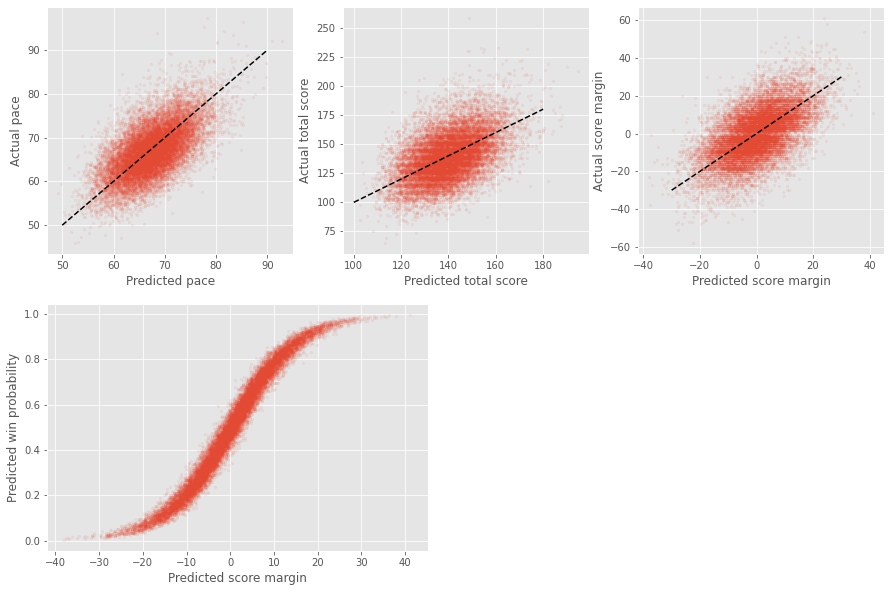

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm


linreg = LinearRegression(fit_intercept=True)

p1 = data.pace1.values
p2 = data.pace2.values
ed = data.effdiff.values
es = data.effsum.values
act_pace = data.poss.values
act_totscore = data.totscore.values
act_margin = data.margin.values

def get_weights(vals):
    # weight pace regression
    mu = vals.mean()
    std = vals.std()
    return 1/np.maximum(0.01,norm.pdf(vals, loc=mu, scale=std))

print("Regression for pace")
X = np.array([p1*p2]).T
linreg.fit(X, act_pace, get_weights(act_pace))
pred_pace = linreg.predict(X)
data["predicted_pace"] = pred_pace
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X, act_pace))
print(mean_absolute_error(act_pace,pred_pace))

print("Regression for total score")
X = np.array([pred_pace*es]).T
linreg.fit(X, act_totscore, get_weights(act_totscore))
pred_score = linreg.predict(X)
data["predicted_totscore"] = pred_score
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X, act_totscore))
print(mean_absolute_error(act_totscore,pred_score))

print("Regression for score margin")
X = np.array([pred_pace*ed, data.HA]).T
linreg.fit(X, act_margin, get_weights(act_margin))
pred_margin = linreg.predict(X)
data["predicted_margin"] = pred_margin
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X, act_margin))
print(mean_absolute_error(act_margin,pred_margin))

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.scatter(data.predicted_pace, data.poss, s=7, alpha=0.07)
plt.plot([50,90],[50,90],'k--')
plt.xlabel('Predicted pace')
plt.ylabel('Actual pace')
plt.subplot(2,3,2)
plt.scatter(data.predicted_totscore, data.totscore, s=7, alpha=0.07)
plt.plot([100,180],[100,180],'k--')
plt.xlabel('Predicted total score')
plt.ylabel('Actual total score')
plt.subplot(2,3,3)
plt.scatter(data.predicted_margin, data.margin, s=7, alpha=0.07)
plt.plot([-30,30],[-30,30],'k--')
plt.xlabel('Predicted score margin')
plt.ylabel('Actual score margin')
plt.subplot(2,2,3)
plt.scatter(data.predicted_margin, data.predicted_prob, s=7, alpha=0.07)
plt.xlabel("Predicted score margin")
plt.ylabel("Predicted win probability")